In [8]:
import os,sys
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob as glob
import numpy as np
import warnings
from scipy.stats import ttest_ind,f_oneway

from fastai import *
from fastai.tabular import *

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

%reload_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings(action='once')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
data_path = os.path.join(os.getcwd(),"Animal State Prediction - dataset")
os.chdir(data_path)
print(data_path)

E:\Projects\ZS_Hackerrank_Feb2020\Animal State Prediction - dataset


In [39]:
train_df = pd.read_csv("train.csv")
train_df.head()
# train_df["intake_datetime"] = pd.to_datetime("intake_datetime")
# train_df["date_of_birth"] = pd.to_datetime("date_of_birth")
# train_df["outcome_datetime"] = pd.to_datetime("outcome_datetime")

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_outcome           47803 non-null  object 
 1   dob_year                    47803 non-null  int64  
 2   dob_month                   47803 non-null  int64  
 3   age_upon_intake             47803 non-null  object 
 4   animal_type                 47803 non-null  object 
 5   breed                       47803 non-null  object 
 6   color                       47803 non-null  object 
 7   intake_condition            47803 non-null  object 
 8   intake_type                 47803 non-null  object 
 9   sex_upon_intake             47802 non-null  object 
 10  count                       47803 non-null  int64  
 11  age_upon_intake_(days)      47803 non-null  int64  
 12  age_upon_intake_(years)     47803 non-null  float64
 13  age_upon_intake_age_group   478

In [41]:
train_df["breed_simple"] = train_df.breed.apply(lambda x: x.split("/")[0])
train_df["breed_simple"] = train_df.breed_simple.apply(lambda x: x.replace(" Mix",""))
train_df["color_simple"] = train_df.color.apply(lambda x: x.split("/")[0])
#train_df.drop(["breed","color"],inplace=True,axis=1)

In [42]:
# COLS_DROP = ["dob_year","dob_month","age_upon_intake","age_upon_intake_(years)","age_upon_intake_age_group",\
#              "intake_datetime","intake_month","intake_year","intake_monthyear","intake_weekday","intake_hour","time_in_shelter",\
#              "age_upon_outcome","date_of_birth","age_upon_outcome_(years)","age_upon_outcome_age_group","outcome_datetime",\
#              "outcome_month","outcome_year","outcome_monthyear","outcome_weekday","outcome_hour","outcome_number"
#             ]

COLS_DROP = ["outcome_datetime"]
train_df.drop(COLS_DROP,axis=1,inplace=True)
train_df.dropna(how="any",inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47802 entries, 0 to 47802
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_outcome           47802 non-null  object 
 1   dob_year                    47802 non-null  int64  
 2   dob_month                   47802 non-null  int64  
 3   age_upon_intake             47802 non-null  object 
 4   animal_type                 47802 non-null  object 
 5   breed                       47802 non-null  object 
 6   color                       47802 non-null  object 
 7   intake_condition            47802 non-null  object 
 8   intake_type                 47802 non-null  object 
 9   sex_upon_intake             47802 non-null  object 
 10  count                       47802 non-null  int64  
 11  age_upon_intake_(days)      47802 non-null  int64  
 12  age_upon_intake_(years)     47802 non-null  float64
 13  age_upon_intake_age_group   478

In [43]:
procs = [FillMissing, Categorify, Normalize]

NUM_COLS = ['count','age_upon_intake_(days)', 'intake_number', 'time_in_shelter_days','age_upon_outcome_(days)']
CAT_COLS = ['animal_type','intake_condition', 'intake_type', 'sex_upon_intake','sex_upon_outcome','breed_simple','color_simple']
RESPONSE = "outcome_type"

In [44]:
data = (TabularList.from_df(train_df, procs=procs, cont_names=NUM_COLS, cat_names=CAT_COLS)
        .split_by_idx(valid_idx=range(int(len(train_df)*0.9),len(train_df)))
        .label_from_df(cols="outcome_type")
#        .add_test(TabularList.from_df(test_df_new, cat_names=cat_names, cont_names=cont_names, procs=procs))
        .databunch())
print(data.train_ds.cont_names)
print(data.train_ds.cat_names)

['count', 'age_upon_intake_(days)', 'intake_number', 'time_in_shelter_days', 'age_upon_outcome_(days)']
['animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake', 'sex_upon_outcome', 'breed_simple', 'color_simple']


In [45]:
learn = tabular_learner(data, layers=[1000,500], metrics=accuracy)

In [47]:
learn.fit_one_cycle(5, 2.5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.269458,1.492989,0.530642,01:38
1,1.262641,1.581244,0.504079,01:35
2,1.227770,1.544312,0.546748,01:36
3,1.249650,1.662254,0.532525,01:35
4,1.237405,1.565981,0.543401,01:36


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


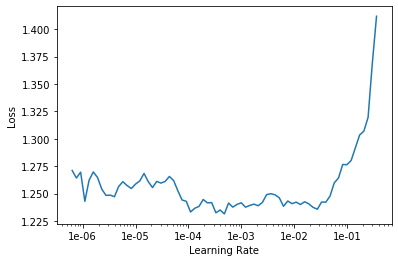

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.228208,1.675012,0.493621,01:36
1,1.246337,1.525549,0.551977,01:35
2,1.264098,1.663676,0.507844,01:36
3,1.208972,1.639627,0.477306,01:35
4,1.266085,1.678928,0.501360,01:38
5,1.237213,1.609128,0.519557,01:35
6,1.246970,1.505629,0.487555,01:36
7,1.260025,1.897211,0.535662,01:35
8,1.228462,1.688317,0.493830,6:59:11
9,1.240021,1.661554,0.512027,01:09


In [ ]:
# preds, _ = learn.get_preds(ds_type=DatasetType.Test)
# pred_prob, pred_class = preds.max(1)

# submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':pred_class})